This Colab illustrates the differing overhead* between a custom, vectorized graph operation and a loop over a tensor
that computes the same function. The loop is implemented in TensorFlow Eager mode using Python syntax and control-flow, and using AutoGraph which takes a python function and converts it into graph mode. In AutoGraph the Python loop is converted into a tf.while_loop.

The actual computation, summing a small number of scalar values, takes very little time to compute, so the graphs below are showing the overhead of the differing approaches. As such, this is more of a "micro-benchmark" than a representation of real-world performance of the three approaches.

*Note the differing scales of the included plots

### Imports

In [0]:
!pip install -U -q tf-nightly

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import random
from colabtools import adhoc_import
from tensorflow.contrib import autograph as ag
from tensorflow.python.framework import function

### Testing boilerplate

In [0]:
# Test-only parameters. Test checks successful completion not correctness. 
burn_ins = 1
trials = 1
batches = 2
max_elements = 2

### Speed comparison parameters

In [0]:
#@test {"skip": true} 
burn_ins = 3 # Batches not counted in the average
trials = 10 # Batches run per vector-size (and averaged)
batches = 1000 # Number of random vectors summed over per trial
max_elements = 100 # Vectors of size 0 to this-1 will be executed and plotted

### Random input

In [0]:
# Construct a random num x 1 tensor
def get_elements(num):
  return tf.random_uniform(shape=(num, 1), maxval=1)

## Graph mode

In [0]:
def tf_sum(elements):
  # Using custom vectorized op
  return tf.reduce_sum(elements)

def run_trial(num):
  elements = get_elements(num)
  return tf_sum(elements)



graph_means = []
for num in range(max_elements):
  with tf.Graph().as_default():
    durations = []
    foo = run_trial(num)
  
    with tf.Session() as sess:
      
      for _ in range(burn_ins):
        for _ in range(batches):
          sess.run(foo)
      
      for _ in range(trials):
      
        start = time.time()
        for _ in range(batches):
          sess.run(foo)
      
        duration = time.time() - start
        durations.append(duration)    
      
    graph_means.append(np.mean(durations))  

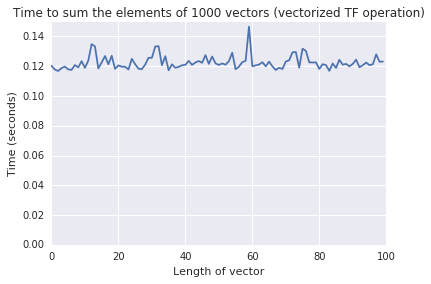

In [0]:
plt.plot(graph_means)
plt.ylabel('Time (seconds)')
plt.xlabel('Length of vector')
_ = plt.title('Time to sum the elements of 1000 vectors (vectorized TF operation)')
_ = plt.ylim(ymin=0)

## AutoGraph

In [0]:
# Sum written using for loop and converted with AutoGraph
def sum_all(elements):
  sum_ = 0.0
  length = len(elements)
  for i in tf.range(length): 
    sum_ += elements[i][0]
  return sum_

def run_trial(num):
  elements = get_elements(num)
  return sum_all(elements)
    
ag_means = []
ag_run_trial = ag.to_graph(run_trial)

for num in range(max_elements):
  with tf.Graph().as_default():
    durations = []
    foo = ag_run_trial(num)
    with tf.Session() as sess:
      for _ in range(burn_ins):
        for _ in range(batches):
          sess.run(foo)
        
      for _ in range(trials):
        start = time.time()
        for _ in range(batches):
          sess.run(foo)
      
        duration = time.time() - start
        durations.append(duration)
    ag_means.append(np.mean(durations))

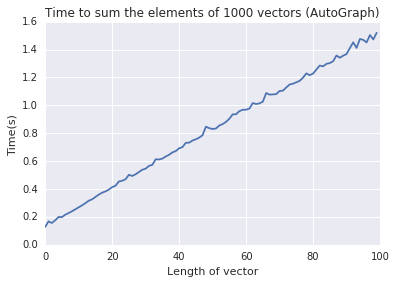

In [0]:
plt.plot(ag_means)
plt.ylabel('Time(s)')
plt.xlabel('Length of vector')
_ = plt.title('Time to sum the elements of 1000 vectors (AutoGraph)')
_ = plt.ylim(ymin=0)

## Eager

In [0]:
from tensorflow.python.eager import context

In [0]:
# Sum written using for loop and run with tf.eager
def sum_all(elements):
  sum_ = 0.0
  length = elements.shape[0]
  for i in tf.range(length): 
    sum_ += elements[i][0]
  return sum_

eager_means = []
for num in range(max_elements):
  with context.eager_mode():
    durations = []
    for i in range(trials + burn_ins):
      
      start = time.time()
      for _ in range(batches):
        run_trial(num)
      
      if i < burn_ins:
        continue
      
      duration = time.time() - start
      durations.append(duration)
    eager_means.append(np.mean(durations))

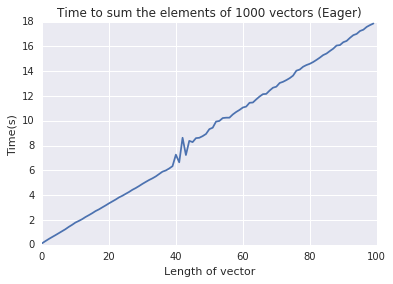

In [0]:
plt.plot(eager_means)
plt.ylabel('Time(s)')
plt.xlabel('Length of vector')
_ = plt.title('Time to sum the elements of 1000 vectors (Eager)')
_ = plt.ylim(ymin=0)